In [1]:
from numpy.random import seed
seed(101)
# from tensorflow import set_random_seed
# set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 1000

In [3]:
print(len(os.listdir(r'C:\Users\HP\Desktop\DRD GRADING\B. Disease Grading\1. Original Images\a. Training Set')))
print(len(os.listdir(r'C:\Users\HP\Desktop\DRD GRADING\B. Disease Grading\1. Original Images\b. Testing Set')))

413
103


In [4]:
df_data = pd.read_csv(r'C:\Users\HP\Desktop\DRD GRADING\B. Disease Grading\2. Groundtruths\train.csv')
print(df_data.shape)

(413, 12)


In [5]:
df_data['Retinopathy grade'].value_counts()

2    136
0    134
3     74
4     49
1     20
Name: Retinopathy grade, dtype: int64

In [6]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, drd in enumerate(categories):
        sample = df[df[col_name]=="0"].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id_code'] + '.jpg'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(no_drd, fontsize=16)  
    plt.tight_layout()
    plt.show()

In [7]:
df_data.head()

,Image name,Retinopathy grade,Risk of macular edema,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,IDRiD_001,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IDRiD_002,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IDRiD_003,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IDRiD_004,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IDRiD_005,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
y = df_data['Retinopathy grade']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(371, 12)
(42, 12)


In [12]:
df_train['Retinopathy grade'].value_counts()

2    122
0    120
3     67
4     44
1     18
Name: Retinopathy grade, dtype: int64

In [13]:
# Create a new directory
base_dir = 'basee_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue

# val_dir
    # a_no_tumor_tissue
    # b_has_tumor_tissue



# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'no_drd')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'drd')
os.mkdir(has_tumor_tissue)


# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'no_drd')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'drd')
os.mkdir(has_tumor_tissue)

In [14]:
os.listdir('base_dir/train_dir')

['drd', 'no_drd']

In [15]:
df_data.set_index('Image name', inplace=True)

In [16]:
# Get a list of train and val images
train_list = list(df_train['Image name'])
val_list = list(df_val['Image name'])

In [17]:
# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.jpg'
    # get the label for a certain image
    target = df_data.loc[image,'Retinopathy grade']
    
    # these must match the folder names
    if target == 0:
        label = 'no_drd'
    if target != 0:
        label = 'drd'
    
    # source path to image
    src = os.path.join(r'C:\Users\HP\Desktop\DRD GRADING\B. Disease Grading\1. Original Images\a. Training Set', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [18]:
# Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.jpg'
    # get the label for a certain image
    target = df_data.loc[image,'Retinopathy grade']
    
    # these must match the folder names
    if target == 0:
        label = 'no_drd'
    if target != 0:
        label = 'drd'
    

    # source path to image
    src = os.path.join(r'C:\Users\HP\Desktop\DRD GRADING\B. Disease Grading\1. Original Images\a. Training Set', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    

In [19]:
print(len(os.listdir('basee_dir/train_dir/no_drd')))
print(len(os.listdir('basee_dir/train_dir/drd')))

120
251


In [20]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/no_drd')))
print(len(os.listdir('base_dir/val_dir/drd')))

181
186


In [24]:
train_path = 'basee_dir/train_dir'
valid_path = 'basee_dir/val_dir'
test_path = r'C:\Users\HP\Desktop\DRD GRADING\B. Disease Grading\1. Original Images\b. Testing Set'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [25]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 371 images belonging to 2 classes.
Found 42 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [26]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 41, 41, 64)       

In [27]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [28]:
print(val_gen.class_indices)

{'drd': 0, 'no_drd': 1}


In [30]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=5, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/5
38/38 [==============================] - 41s 1s/step - loss: 0.6349 - accuracy: 0.6765 - val_loss: 0.6369 - val_accuracy: 0.6667
Epoch 2/5
38/38 [==============================] - 36s 948ms/step - loss: 0.6183 - accuracy: 0.6765 - val_loss: 0.5982 - val_accuracy: 0.6667
Epoch 3/5
38/38 [==============================] - 38s 992ms/step - loss: 0.6071 - accuracy: 0.6765 - val_loss: 0.5787 - val_accuracy: 0.6667
Epoch 4/5
38/38 [==============================] - 37s 962ms/step - loss: 0.6001 - accuracy: 0.6765 - val_loss: 0.5322 - val_accuracy: 0.6667
Epoch 5/5
38/38 [==============================] - 35s 912ms/step - loss: 0.5640 - accuracy: 0.6765 - val_loss: 0.4933 - val_accuracy: 0.6667


In [31]:

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


val_loss: 0.4933023452758789
val_acc: 0.6666666865348816


In [32]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


42/42 [==============================] - 3s 66ms/step


In [33]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_drd', 'drd'])

df_preds.head()

,no_drd,drd
0,0.966275,0.033725
1,0.986137,0.013863
2,0.815277,0.184723
3,0.969597,0.030403
4,0.929629,0.070371


In [34]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['drd']

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.8596938775510203

In [36]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [37]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [38]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[28  0]
 [14  0]]


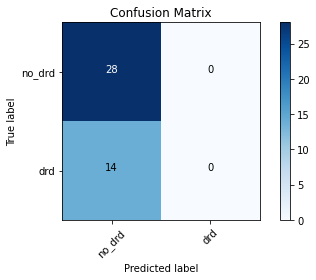

In [39]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_drd', 'drd']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [40]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary,target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      no_drd       0.67      1.00      0.80        28
         drd       0.00      0.00      0.00        14

    accuracy                           0.67        42
   macro avg       0.33      0.50      0.40        42
weighted avg       0.44      0.67      0.53        42



C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
